Data Product Citations:

Didan, K. (2021). MODIS/Aqua Vegetation Indices 16-Day L3 Global 250m SIN Grid V061. NASA EOSDIS Land Processes Distributed Active Archive Center. Accessed 2023-10-06 from https://doi.org/10.5067/MODIS/MYD13Q1.061. Accessed October 6, 2023. 

In [71]:
import logging
import os
import pathlib
import subprocess
import warnings

from glob import glob

import earthpy.appeears as etapp
import folium
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import pandas as pd
import rioxarray as rxr
import xarray as xr

# Set up logging so AppeearsDownloader will log in notebook
logging.basicConfig(level=logging.INFO)

# Ignore FutureWarning coming from hvplot
warnings.simplefilter(action='ignore', category=FutureWarning)

In [72]:
# Create a variable `campfire_data_path` that stores the
# path to a directory.

royal_gorge_data_path = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'royal-gorge-fire')

# Create the directory specified by `campfire_data_path` if
#  it doesn't already exist.
os.makedirs(royal_gorge_data_path, exist_ok=True)

# Return the path to the 'camp-fire' data directory.
royal_gorge_data_path

'/home/jovyan/earth-analytics/data/royal-gorge-fire'

In [133]:
# YOUR CODE HERE
#raise NotImplementedError()

royal_gorge_data_url = (
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/"
    "services/Historic_Geomac_Perimeters_2013/FeatureServer/0/"
    "query?where=latest%20%3D%20'Y'%20AND%20uniquefireidentifier"
    "%20%3D%20'2013-CORGD-000328'&outFields=*&outSR=4326&f=json"
)

royal_gorge_data = gpd.read_file(royal_gorge_data_url)
royal_gorge_data

,OBJECTID,agency,comments,active,latest,uniquefireidentifier,complexname,gisacres,perimeterdatetime,incidentname,...,pooresponsibleunit,firecode,localincidentidentifier,inciwebid,incomplex,state,complexfirecode,shape__Area,shape__Length,geometry
0,1322,BLM,FIMT,N,Y,2013-CORGD-000328,NaN,3220.798768,1371393420000,Royal Gorge,...,CORGD,HJ8S,000328,3419,N,CO,NaN,2.128935e+07,37158.042834,"MULTIPOLYGON (((-105.28614 38.48012, -105.2855..."


### Site Map

The code below will help you to draw the Tribal subdivision boundaris on an interactive map.

&#128187; Your task:
  * Ask ChatGPT [how to plot a shapefile on a folium map](https://chat.openai.com/share/25988d5d-b355-4537-b2a1-71eafc60f67e)
  * Adapt the code to use the boundary data you downloaded
  * Add a labeled marker for Paradise, CA
  * Center the map at that same location with a reasonable `zoom_start` level

> **GOTCHA ALERT:** Make sure to call your map at the end of the cell so that it will display in your Notebook

&#127798; Customize your plot - can you add ESRI World Imagery as the basemap/background?


In [74]:
# Read the shapefile
gdf = gpd.read_file(royal_gorge_data_url)

#Initialize location
fire_lat = 38.4311
fire_lon = -105.2689

# Create a Folium map object
m = folium.Map(
    # Location to display
    location=(fire_lat, fire_lon),
    # Change the initial zoom
    zoom_start=12, 
    # Turns off annoying zooming while trying to scroll to the next cell
    scrollWheelZoom=False)


# Change the basemap images to ESRI World Imagery
esri_world_imagery_url = 'https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'

folium.TileLayer(
    tiles=esri_world_imagery_url,
    attr='ESRI',
    name='ESRI World Imagery',
    overlay=True
).add_to(m)

# Add a Title
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Royal Gorge Fire Boundary</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Convert the GeoDataFrame to GeoJSON format
geojson_data = gdf.to_json()

# Add the GeoJSON data to the map as a GeoJson layer
folium.GeoJson(geojson_data).add_to(m)

# Save the map as an HTML file or display it inline
# m.save('map.html')
# OR
m

In [75]:
# Define the parameters
ndvi_downloader = etapp.AppeearsDownloader(
    download_key='modis-ndvi-4',
    ea_dir=royal_gorge_data_path,
    product='MYD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date='06-01',
    end_date='08-31',
    recurring=True,
    year_range=[2010, 2023],
    polygon=royal_gorge_data
)

# Download files if the download directory does not exist
if not os.path.exists(ndvi_downloader.data_dir):
    ndvi_downloader.download_files()

## Putting it together: Working with multi-file raster datasets in Python

Now you need to load all the downloaded files into Python. Let's start by getting all the file names. You will also need to extract the date from the filename. Check out [the lesson on getting information from filenames in the textbook](https://www.earthdatascience.org/courses/intro-to-earth-data-science/write-efficient-python-code/loops/data-workflows-with-loops/).

> **GOTCHA ALERT:** `glob` doesn't necessarily find files in the order you would expect. Make sure to **sort** your file names like it says in the textbook.

In [109]:
# YOUR CODE HERE
# raise NotImplementedError()

ndvi_path_list = glob(os.path.join(
    ndvi_downloader.data_dir, '*', '*NDVI*.tif'))

ndvi_path_list

['/home/jovyan/earth-analytics/data/royal-gorge-fire/modis-ndvi-4/MYD13Q1.061_2010137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2015217_aid0001.tif',
 '/home/jovyan/earth-analytics/data/royal-gorge-fire/modis-ndvi-4/MYD13Q1.061_2010137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2010185_aid0001.tif',
 '/home/jovyan/earth-analytics/data/royal-gorge-fire/modis-ndvi-4/MYD13Q1.061_2010137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2021185_aid0001.tif',
 '/home/jovyan/earth-analytics/data/royal-gorge-fire/modis-ndvi-4/MYD13Q1.061_2010137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2021201_aid0001.tif',
 '/home/jovyan/earth-analytics/data/royal-gorge-fire/modis-ndvi-4/MYD13Q1.061_2010137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2011233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/royal-gorge-fire/modis-ndvi-4/MYD13Q1.061_2010137_to_2023243/MYD13Q1.061__250m_16_days_NDVI_doy2013233_aid0001.tif',
 '/home/jovyan/earth-analytics/data/royal-gorge-fire/modis-ndvi-4/MYD13Q1.061_2010

In [110]:
# Define start and and end days
doy_start = -19
doy_end = -12
scale_factor = 10000

ndvi_da_list = []
for ndvi_path in ndvi_path_list:
    # Get date from file name
    doy = ndvi_path[doy_start:doy_end]
    date = pd.to_datetime(doy, format='%Y%j')

    # Open Dataset
    da = rxr.open_rasterio(ndvi_path, masked=True).squeeze()

    da = da.assign_coords({'date': date})
    da = da.expand_dims({'date': 1})
    da.name = 'NDVI'

    # Divide by scale factor
    da = da / scale_factor
    # Add the DataArray to the end of the accumulator list
    ndvi_da_list.append(da)

ndvi_da_list

[<xarray.DataArray 'NDVI' (date: 1, y: 21, x: 42)>
 array([[[0.3692, 0.4032, 0.4032, 0.4032, 0.3876, 0.402 , 0.402 , 0.4186,
          0.4186, 0.415 , 0.4231, 0.4231, 0.3773, 0.4109, 0.4109, 0.4109,
          0.4248, 0.4355, 0.4384, 0.4617, 0.4617, 0.5027, 0.5501, 0.5227,
          0.5066, 0.5066, 0.4611, 0.4611, 0.4461, 0.4461, 0.5075, 0.5075,
          0.44  , 0.4285, 0.4285, 0.4285, 0.3483, 0.3529, 0.3529, 0.3711,
          0.3711, 0.3997],
         [0.3919, 0.3919, 0.4027, 0.4027, 0.3837, 0.4232, 0.4232, 0.4067,
          0.4067, 0.4146, 0.4146, 0.3931, 0.4221, 0.3914, 0.3914, 0.3914,
          0.3976, 0.4241, 0.4434, 0.4434, 0.4611, 0.4611, 0.5063, 0.481 ,
          0.481 , 0.481 , 0.4218, 0.4325, 0.5043, 0.5043, 0.501 , 0.501 ,
          0.4504, 0.4504, 0.4134, 0.4058, 0.3662, 0.3521, 0.3521, 0.3945,
          0.3945, 0.4016],
         [0.3839, 0.3991, 0.3861, 0.3861, 0.3918, 0.3918, 0.4383, 0.4085,
          0.4085, 0.4085, 0.3945, 0.412 , 0.4221, 0.4418, 0.4418, 0.4418,
       

In [111]:
ndvi_ds = xr.combine_by_coords(ndvi_da_list, coords=['date'])
ndvi_ds

<xarray.Dataset>
Dimensions:      (x: 42, y: 21, date: 95)
Coordinates:
    band         int64 1
  * x            (x) float64 -105.4 -105.4 -105.4 ... -105.3 -105.3 -105.3
  * y            (y) float64 38.48 38.48 38.48 38.47 ... 38.44 38.44 38.44 38.44
    spatial_ref  int64 0
  * date         (date) datetime64[ns] 2010-05-17 2010-06-02 ... 2023-08-21
Data variables:
    NDVI         (date, y, x) float32 0.3041 0.3048 0.3048 ... 0.3685 0.21

In [144]:
import hvplot.xarray
import holoviews as hv

# Calculate the NDVI difference for 2023 and 2012
ndvi_diff = (ndvi_ds
            .sel(date='2023')
            .mean('date')
            .NDVI
            - ndvi_ds
            .sel(date='2012')
            .mean('date')
            .NDVI
 )

# Create a holoviews image plot for the NDVI difference
image_plot = ndvi_diff.hvplot.image(cmap='PiYG', title="NDVI Difference Plot:\nPre and Post Fire Years (2012 - 2014)")

# Rotate x-axis ticks by 90 degrees and set axis labels
image_plot.opts(xlabel='Latitude (WGS84)', ylabel='Longitude (WGS84)')

# Display the plots
(image_plot)

# Save the plot as an HTML file
hv.save(image_plot, 'ndvi_pre_post_fire_years.html')

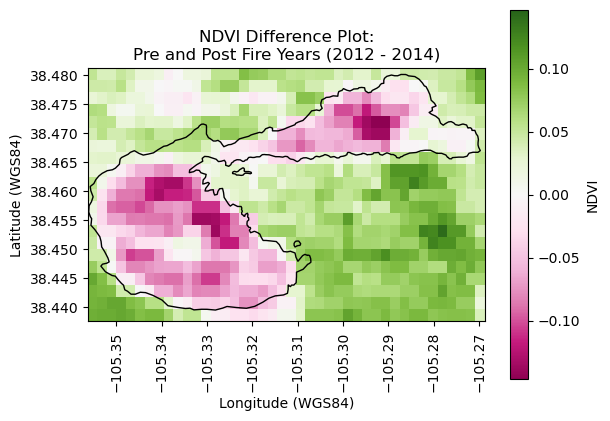

In [155]:
import matplotlib.pyplot as plt

dndvi_da = (ndvi_ds
            .sel(date='2023')
            .mean('date')
            .NDVI
            - ndvi_ds
            .sel(date='2012')
            .mean('date')
            .NDVI
 )

dndvi_da.plot(cmap=plt.colormaps['PiYG'])
royal_gorge_data.plot(facecolor='none',ax=plt.gca())

# Add a title
plt.title("NDVI Difference Plot:\nPre and Post Fire Years (2012 - 2014)")

# Rotate x-axis ticks by 90 degrees and change labels
plt.xticks(rotation=90)
plt.xlabel('Longitude (WGS84)')  # Set the x-axis label
plt.ylabel('Latitude (WGS84)')   # Set the y-axis label

#plt.show()
#plt.savefig('ndvi_pre_post_fire_years_histogram.png')

# Create a histogram plot
hist_plot = dndvi_da.hvplot.hist(title="Histogram Plot")


# Display the plot
hist_plot

# Save the plot as an HTML file
hv.save(image_plot, 'ndvi_pre_post_fire_histogram.html')

In [80]:
out_gdf = (
    gpd.GeoDataFrame(geometry=royal_gorge_data.envelope)
    .overlay(royal_gorge_data, how='difference')
)
out_gdf

,geometry
0,"MULTIPOLYGON (((-105.35610 38.43945, -105.3561..."


In [81]:
# Check plot is coming out fine
# ndvi_ds.rio.clip(camp_fire_data.geometry).NDVI.sel(date='2019-05').plot()

# Check same projection
# ndvi_ds.rio.clip(camp_fire_data.geometry)
# ndvi_ds.rio.crs, camp_fire_data.crs

ndvi_fire_ds = ndvi_ds.rio.clip(royal_gorge_data.geometry)
ndvi_out_ds = ndvi_ds.rio.clip(out_gdf.geometry)

In [82]:
ndvi_fire_df = (
    ndvi_fire_ds
    .groupby(ndvi_fire_ds.date.dt.year)
    .mean(...)
    .NDVI
    .to_dataframe()[['NDVI']]
)

ndvi_out_df = (
    ndvi_out_ds
    .groupby(ndvi_out_ds.date.dt.year)
    .mean(...)
    .NDVI
    .to_dataframe()[['NDVI']]
)

print(round((ndvi_fire_df - ndvi_out_df).sum(), 2).sum())
ndvi_fire_df, ndvi_out_df

-0.31


(          NDVI
 year          
 2010  0.399931
 2011  0.371596
 2012  0.375501
 2013  0.266665
 2014  0.315280
 2015  0.369456
 2016  0.311826
 2017  0.347753
 2018  0.284144
 2019  0.316784
 2020  0.283654
 2021  0.336867
 2022  0.299974
 2023  0.327777,
           NDVI
 year          
 2010  0.346259
 2011  0.304322
 2012  0.308306
 2013  0.322763
 2014  0.370619
 2015  0.409772
 2016  0.370617
 2017  0.388664
 2018  0.330341
 2019  0.363807
 2020  0.326250
 2021  0.377898
 2022  0.333961
 2023  0.363050)

In [151]:
#(ndvi_fire_df - ndvi_out_df).hvplot(title="NDVI Difference Plot")

import hvplot.pandas as hvplot
import holoviews as hv

# Assuming you have your dataframes ndvi_fire_df and ndvi_out_df defined

# Calculate the difference
ndvi_diff = ndvi_fire_df - ndvi_out_df

# Create a vertical line
vertical_line = hv.Curve([(2013, -0.07), (2013, 0.07)], label="Fire Year").opts(line_dash="dashed")

# Create your original plot
original_plot = ndvi_diff.hvplot(title="NDVI Recovery to Present",label="NDVI")

# Combine the original plot and the vertical line
combined_plot = (original_plot * vertical_line).opts(legend_position="top_right")

# Display the combined plot
combined_plot

# Save the plot as an HTML file
hv.save(image_plot, 'ndvi_pre_post_fire_to_present.html')

The vegetation was close to recovering two years after the fire. NDVI does not allow us to be able to tell the difference between forest growth and different types of greenery. Likely, only flowers and grasses have recovered, while trees would most likely take much longer.

## Your turn! Repeat this workflow in a different time and place for your portfolio.

It's not just water rights that affect NDVI! You could look at: 
  * Recovery after a national disaster, like a wildfire or hurricane
  * The effects of drought on crop health
  * Deforestation

You can even choose a different dataset, like Landsat, and/or a different spectral index. [Check out some other ways to enhance images and highlight different phenomena](https://www.usgs.gov/landsat-missions/landsat-surface-reflectance-derived-spectral-indices)